# Estimation of the Mean Function of Functional Data via Deep Neural Networks

In [92]:
# nibabel documentation: https://nipy.org/nibabel/gettingstarted.html
# https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/#:~:text=The%20number%20of%20epochs%20is%20a%20hyperparameter%20that%20defines%20the,update%20the%20internal%20model%20parameters.

In [1]:
import pandas as pd
import numpy as np
from itertools import product
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Flatten, Dense, Dropout)
import nibabel as nib
from nibabel.testing import data_path

import pydot_ng
import pydot
import pydotplus
import graphviz
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', None)

In [2]:
images = nib.load('data.nii')

In [3]:
data = images.get_fdata().T #transpose the original data - it should fit the format 95*79

In [4]:
data[20].shape

(95, 79)

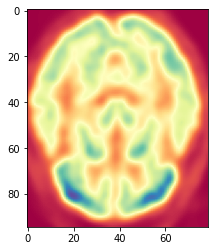

In [5]:
plt.imshow((data[20]), cmap='Spectral')
plt.show()

# Data definition
- There are 69 images slices contained in a 3D data cube.
- We use one slice from a given cube.
- When combining with other slices from other images we need to make sure that we select the slice from the same position inside the cube.
- Each image slice is a 95x79 matrix.
- Each row of the matrix is the output vector which needs to be predicted. These are the individual pixels in the image.
- To predict the output we need to generate the features which are the coordinates of each pixel in the output vector.
- The coordinates need to be normalized to 1 so for each coordinate needs to be divided by the $L_0$ norm of the vector.
    - Example: for the first pixel the coordinates will be $(\frac{1}{95},\frac{1}{79})$ and for the last pixel the coordinates will be $(\frac{1}{95}, \frac{79}{79})$
-------------------------------------------------------

# Model input and output
## Input: a set of coordinates e.g. $(\frac{1}{95},\frac{1}{79})$

### X:
- Get all the first coordinates as first column of the input matrix
- Get all the second coordinates as the second column of the input matrix
----------------------------------------------------------
## Output: predicted value for the pixel at that coordinate.

### Y:
- Take the matrix that contains the actual pixels for each image (this is the desired output) and ravel the array to get it into a single array of 95*79 elements each corresponding to the pixel value that needs to be predicted.
    - example: for an image with dimensions 95x79 - the total number of coordinate sets should be 95*79
    - the number of coordinates should be exactly the same as the number of pixels in the image - this will give a 1:1 correspondence between coordinates and pixels
    - even though as the image changes the pixels in the image change - the coordinates will remain the same for each pixel.

In [1]:
l = [1,2,3,4]
l

[1, 2, 3, 4]

In [2]:
l[0]

1

In [6]:
# i, j = np.indices(dimensions=(95,79), sparse=True)
# del i, j

In [7]:
#this gives you coordinates as two separate arrays 1 for each coordinate. Since the original matrix to be predicted is 95 rows, we get two arrays of length 95 - one for each coordinate
# np.indices(dimensions=(95,79)).shape 

In [52]:
# %%writefile utils/preprocessing.py
import pandas as pd
import numpy as np
import nibabel as nib
from nibabel.testing import data_path

def preprocess_image(img, img_slice=10):
    """
    Input: 
        img: Image as nii file - data cube with slices for an image
        img_slice: integer to specify which slice to select
    Return 
        X: dataframe with two columns containing X and Y coordinates.
        Y: flattened pixel values
    """
    images = nib.load(img)
    data = images.get_fdata().T #transpose the original data - it should fit the format 95*79
    
    Y = data[20].ravel() #flatten the matrix of pixels into a single array
    Y = pd.DataFrame(Y, columns=['pixel_value']) #for the first image
    
    #get the number of rows and columns for the matrix of pixels per image
    rows = data[20].shape[0] #number of rows
    cols = data[20].shape[1] #number of columns

    #generate coordinates
    row_indices = list()
    column_indices = list()

    row_coordinates =  (np.indices(dimensions=(rows, cols))[0]+1)*(1/rows) #add 1 to avoid start from 0 - multiply by 1/cols to notmalize
    column_coordinates =  (np.indices(dimensions=(rows, cols))[1]+1)*(1/cols) #add 1 to avoid start from 0 - multiply by 1/cols to notmalize

    for row in row_coordinates:
        for row_index in row:
            row_indices.append(row_index)

    for row in column_coordinates:
        for column_index in row:
            column_indices.append(column_index)
            
    X = pd.DataFrame(columns=['X_coordinate', 'Y_coordinate'])
    X['X_coordinate'] = np.array(row_indices)
    X['Y_coordinate'] = np.array(column_indices)
    
    return X, Y

- Should coordinates and pixels values for all images be stacked and one combined dataset be created?

## Models

In [53]:
# %%writefile models/dnn_model.py
import pandas as pd
import numpy as np
from itertools import product
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Flatten, Dense, Dropout)
import matplotlib.pyplot as plt

class Callback(tf.keras.callbacks.Callback):
    epoch_controller = 25

    def on_epoch_end(self, epoch, logs=None):
        self.epoch = epoch
        if (self.epoch%self.epoch_controller==0):
            print('Epoch: ' + str(self.epoch) + ' loss: ' + str(logs['loss']))
        
def dnn_model(X_train, 
          Y_train, 
          neurons_per_layer=1000,
          activation_per_layer='relu',
          epochs=500, 
          dropout_rate=0.25, 
          loss='huber', 
          l1_regularizer=False,
          batch_size=32,
          verbose=0):
    """
    create and return the desired model
    """
    #regularizer
    if l1_regularizer:
        regularizer=tf.keras.regularizers.L1(l1=0.01)
    else:
        regularizer=None
    
    model = keras.models.Sequential([
        Flatten(input_shape=X.shape[1:]),
        Dense(neurons_per_layer, activation=activation_per_layer, kernel_regularizer=regularizer),
        Dense(neurons_per_layer, activation=activation_per_layer, kernel_regularizer=regularizer),
        Dense(neurons_per_layer, activation=activation_per_layer, kernel_regularizer=regularizer),
        Dropout(dropout_rate),
        Dense(1)
    ])
            
    #define loss to minimize
    if loss=='huber':
        loss_to_minimize = tf.keras.losses.Huber() 
    elif loss=='mse':
        loss_to_minimize = tf.keras.losses.MeanSquaredError()
    
    #optimizer
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, 
        amsgrad=False, name='Adam'
    )
    
    #compile the model
    model.compile(loss=loss_to_minimize, 
                  optimizer=optimizer)
    
    #model fit
    model_history = model.fit(X_train, Y_train, 
                              batch_size=batch_size, 
                              epochs=epochs,  
                              callbacks=[Callback()], 
                              verbose=verbose)
    
    return model_history, model


def train_predict(X, Y, **model_params):
    """
    Train and predict pixel values from the model
    """
    neurons_per_layer = model_params["neurons_per_layer"] if "neurons_per_layer" in model_params else 100
    activation_per_layer = model_params["activation_per_layer"] if "activation_per_layer" in model_params else "relu"
    epochs = model_params["epochs"] if "epochs" in model_params else 100
    dropout_rate = model_params["dropout_rate"] if "dropout_rate" in model_params else 0.25
    loss = model_params["loss"] if "loss" in model_params else "mse"
    l1_regularizer = model_params["l1_regularizer"] if "l1_regularizer" in model_params else True
    verbose = model_params["verbose"] if "verbose" in model_params else 0
    
    model_history, model = dnn_model(X, Y,
                                     neurons_per_layer=neurons_per_layer,
                                     activation_per_layer=activation_per_layer, 
                                     epochs=epochs, 
                                     dropout_rate=dropout_rate, 
                                     loss=loss, 
                                     l1_regularizer=l1_regularizer, 
                                     verbose=verbose)
    y_pred = model.predict(X)
    
    plt.imshow(np.reshape(y_pred, (95, 79)), cmap='gray') #display the recovered image
    
    return model, model_history, y_pred

In [49]:
model_params = {"neurons_per_layer": 1000,
               "activation_per_layer": "relu",
               "epochs": 300,
               "dropout_rate": 0.2,
               "loss": "mse",
               "l1_regularizer": True,
               "verbose": 0}

Epoch: 0 loss: 49.07072448730469
Epoch: 25 loss: 2.659883737564087
Epoch: 50 loss: 2.650146961212158
Epoch: 75 loss: 2.6463637351989746
Epoch: 100 loss: 2.6453113555908203
Epoch: 125 loss: 2.642965793609619
Epoch: 150 loss: 2.642335891723633
Epoch: 175 loss: 2.6422996520996094
Epoch: 200 loss: 2.6415135860443115
Epoch: 225 loss: 2.6408798694610596
Epoch: 250 loss: 2.6408329010009766
Epoch: 275 loss: 2.640795946121216


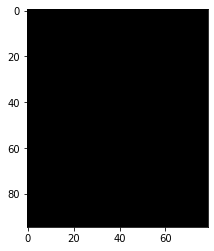

In [48]:
X, Y = preprocess_image("images/data.nii", img_slice=20)
model, model_history, y_pred = train_predict(X, Y, **model_params)

In [54]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 2)                 0         
                                                                 
 dense_12 (Dense)            (None, 1000)              3000      
                                                                 
 dense_13 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_14 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_3 (Dropout)         (None, 1000)              0         
                                                                 
 dense_15 (Dense)            (None, 1)                 1001      
                                                                 
Total params: 2,006,001
Trainable params: 2,006,001
No

In [12]:
# keras.utils.plot_model(dnn_model)

In [72]:
data[20].shape

(95, 79)

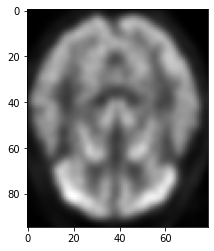

In [73]:
plt.imshow((data[20]), cmap='gray')

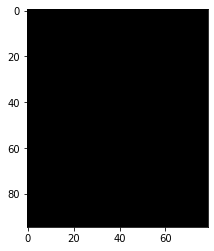

In [55]:
plt.imshow(np.reshape(y_pred, (95, 79)), cmap='gray')